In [2]:
import pandas as pd
from pandas import read_csv
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense, Flatten, ConvLSTM1D,ConvLSTM2D, MaxPooling2D
from keras.layers import Dropout
from keras import Model
from keras.layers import Layer
import keras.backend as K

from keras.models import Sequential
from keras.metrics import mean_squared_error
from keras.layers import Input, Dense, SimpleRNN

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
biological_data = pd.read_csv("biological_data.csv").drop('Unnamed: 0', axis=1)

In [3]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

human_data = biological_data.copy()
human_data['X2'] = human_data.apply(lambda x: getKmers(x['X2']), axis=1)
human_data['X3'] = human_data.apply(lambda x: getKmers(x['X3']), axis=1)

human_data_X2 = list(human_data['X2'])
human_data_X3 = list(human_data['X3'])
for item in range(len(human_data)):
    human_data_X2[item] = ' '.join(human_data_X2[item])
    human_data_X3[item] = ' '.join(human_data_X3[item])
    
y_data = human_data.iloc[:, 0].values
#Normalize y data
y_data = np.array(normalize([y_data]))
y_data = y_data.reshape(-1)

# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing

cv = CountVectorizer(ngram_range=(4,4))
X2 = cv.fit_transform(human_data_X2)
X3 = cv.fit_transform(human_data_X3)

X_train, X_test, y_train, y_test = train_test_split(X2.toarray(), y_data, test_size = 0.20, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [4]:
# Set up parameters
time_steps = 185
hidden_units = 2
epochs = 50

# Create a traditional RNN network
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

RNNmodel = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])

2023-01-16 15:29:33.873158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 15:29:33.873535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 15:29:33.877440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 15:29:33.877812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 15:29:33.878298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 1/50
1596/1596 [==============================] - 49s 30ms/step - loss: 0.0046 - val_loss: 3.6170e-04
Epoch 2/50
1596/1596 [==============================] - 48s 30ms/step - loss: 3.4056e-04 - val_loss: 3.3500e-04
Epoch 3/50
1596/1596 [==============================] - 48s 30ms/step - loss: 3.3691e-04 - val_loss: 3.1501e-04
Epoch 4/50
1596/1596 [==============================] - 48s 30ms/step - loss: 3.3381e-04 - val_loss: 3.6182e-04
Epoch 5/50
1596/1596 [==============================] - 48s 30ms/step - loss: 3.3794e-04 - val_loss: 3.2619e-04
Epoch 6/50
1596/1596 [==============================] - 48s 30ms/step - loss: 3.1912e-04 - val_loss: 3.2106e-04
Epoch 7/50
1596/1596 [==============================] - 48s 30ms/step - loss: 3.2178e-04 - val_loss: 3.1192e-04
Epoch 8/50
1596/1596 [==============================] - 48s 30ms/step - loss: 3.1760e-04 - val_loss: 3.0733e-04
Epoch 9/50
1596/1596 [==============================] - 49s 31ms/step - loss: 3.1099e-04 - val_loss: 3.2820e

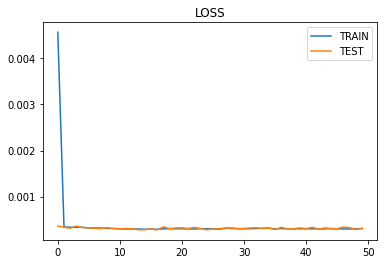

In [5]:
history = RNNmodel.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_test, y_test))

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("LOSS")
plt.legend(["TRAIN" , "TEST"])
plt.show()

13/13 [==============================] - 0s 10ms/step


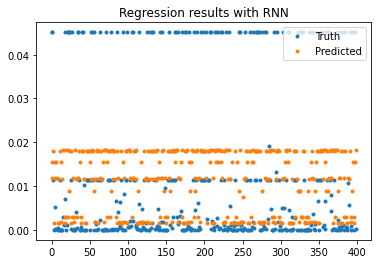

In [6]:
y_pred = RNNmodel.predict(X_test)
x = np.arange(399)
plt.figure()
plt.plot(x,y_test, '.')
plt.plot(x,y_pred, '.')
plt.legend(["Truth", "Predicted"], loc ="upper right")
plt.title("Regression results with RNN")
plt.show()

In [7]:
# Add attention layer to the model
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(RNN_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model    

In [8]:
# Create the model with attention, train and evaluate
model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1, 
                                  input_shape=(time_steps,1), activation='tanh')
model_attention.summary()    
model_attention.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 185, 1)]          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 185, 2)            8         
                                                                 
 attention (attention)       (None, 2)                 187       
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 198
Trainable params: 198
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1596/1596 [==============================] - 66s 41ms/step - loss: 0.0082 - val_loss: 3.1032e-04
Epoch 2/50
1596/1596 [==============================] - 65s 41ms/step - loss: 3.0192e-0

13/13 [==============================] - 0s 10ms/step


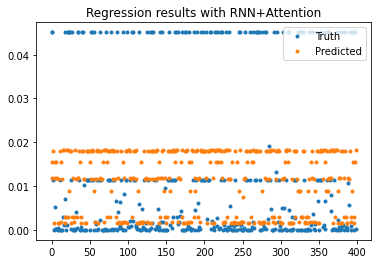

In [9]:
y_pred = RNNmodel.predict(X_test)
x = np.arange(399)
plt.figure()
plt.plot(x,y_test, '.')
plt.plot(x,y_pred, '.')
plt.legend(["Truth", "Predicted"], loc ="upper right")
plt.title("Regression results with RNN+Attention")
plt.show()